## Model Compression using SVD (MNIST)

Epoch 1/2
235/235 [==============================] - 11s 43ms/step - loss: 0.2385 - accuracy: 0.9262
Epoch 2/2
313/313 [==============================] - 3s 9ms/step - loss: 0.1008 - accuracy: 0.9718
Baseline Test Accuracy: 0.9718000292778015


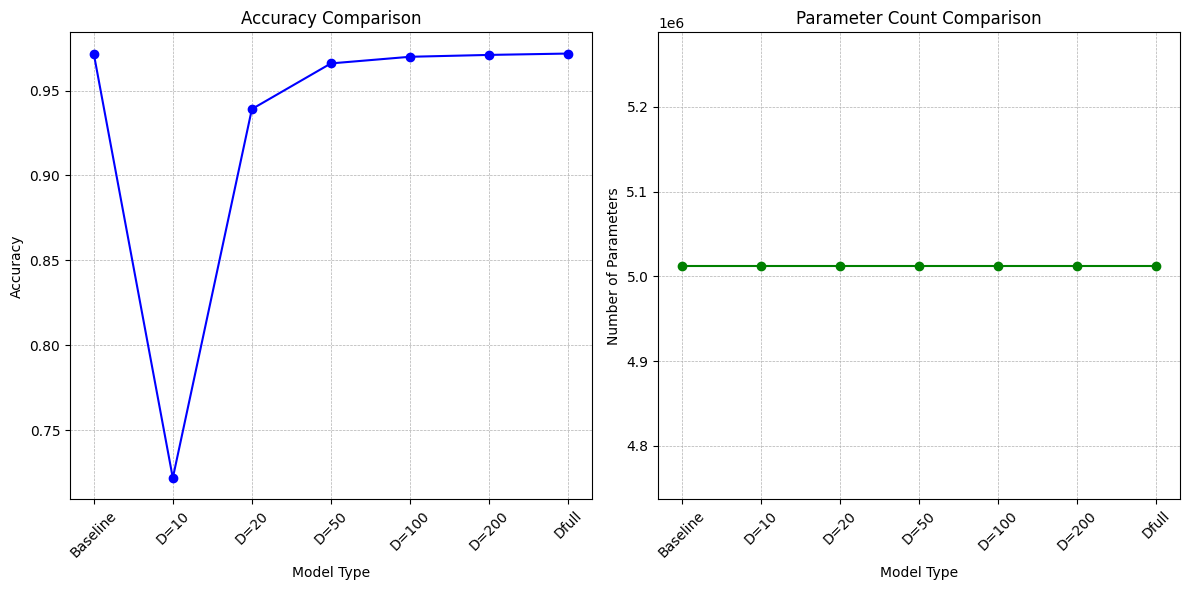

[0.9718000292778015, 0.7218000292778015, 0.9391000270843506, 0.9660000205039978, 0.9699000120162964, 0.9710000157356262, 0.9718000292778015]
[5012490, 5012490, 5012490, 5012490, 5012490, 5012490, 5012490]


In [6]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

# Model
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size = 256)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Baseline Test Accuracy:", test_acc)




# SVD Function
def svd_on_layer(W, D):
    U, S, Vt = np.linalg.svd(W, full_matrices=False)
    if D is None: # Dfull
        return np.dot(U, np.dot(np.diag(S), Vt))
    else:
        return np.dot(U[:, :D], np.dot(np.diag(S[:D]), Vt[:D, :]))
    
    
    
    
# SVD Funciton with series of D and Dfull for baseline model
def apply_svd_to_model(model, D_values):
    svd_models = []
    for D in D_values:
        svd_model = keras.models.clone_model(model)
        svd_model.set_weights(model.get_weights())
        
        for i in range(1, 6): # Iterate for 5 layers!!!
            W = svd_model.layers[i].get_weights()[0]
            b = svd_model.layers[i].get_weights()[1]
            W_svd = svd_on_layer(W, D)
            svd_model.layers[i].set_weights([W_svd, b])
        
        # Compile!!
        svd_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        svd_models.append(svd_model)
    return svd_models

D_values = [10, 20, 50, 100, 200, None]
svd_models = apply_svd_to_model(model, D_values)




# Accuracies and parameters

accuracies = []
param_counts = []

# Add oroginal acc
param_counts.append(model.count_params())
accuracies.append(test_acc)

for svd_model in svd_models:
    loss, acc = svd_model.evaluate(x_test, y_test, verbose=0)
    accuracies.append(acc)
    param_counts.append(svd_model.count_params())
    
labels = ['Baseline', 'D=10', 'D=20', 'D=50', 'D=100', 'D=200', 'Dfull']

plt.figure(figsize=(12, 6))

# Acc graph
plt.subplot(1, 2, 1)
plt.plot(labels, accuracies, marker='o', color='blue', linestyle='-')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

# Parameter graph 
plt.subplot(1, 2, 2)
plt.plot(labels, param_counts, marker='o', color='green', linestyle='-')
plt.xlabel('Model Type')
plt.ylabel('Number of Parameters')
plt.title('Parameter Count Comparison')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(accuracies)
print(param_counts)

## Factorized Dense Layers with SVD (MNIST)

In [55]:
# SVD function

def svd_factorized_layer(W, D):
    U, S, Vt = np.linalg.svd(W, full_matrices=False)
    U_D = U[:, :D]
    S_D = np.diag(S[:D])
    Vt_D = Vt[:D, :]
    return U_D, S_D, Vt_D



# D 20 Model 
def build_svd_compressed_model(model, D=20):
    compressed_model = models.Sequential()
    compressed_model.add(layers.Flatten(input_shape=(28, 28)))
    
    for i in range(1, 6):
        W = model.layers[i].get_weights()[0]
        b = model.layers[i].get_weights()[1]

        U_D, S_D, Vt_D = svd_factorized_layer(W, D)
        
        if i == 1:
            compressed_model.add(layers.Dense(D, activation='relu', input_shape=(28*28,), weights=[U_D, np.zeros(D)]))
            compressed_model.add(layers.Dense(1024, activation='relu', weights=[np.dot(S_D, Vt_D), b]))
        else:
            compressed_model.add(layers.Dense(D, activation='relu', weights=[U_D, np.zeros(D)]))
            compressed_model.add(layers.Dense(1024, activation='relu', weights=[np.dot(S_D, Vt_D), b]))

    compressed_model.add(layers.Dense(10, activation='softmax'))

    return compressed_model



# Implementing and tune
compressed_model = build_svd_compressed_model(model)
compressed_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), 
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
compressed_model.fit(x_train, y_train, epochs=10, batch_size = 512)
compressed_test_loss, compressed_test_acc = compressed_model.evaluate(x_test, y_test)
print("SVD Compressed Test Accuracy:", compressed_test_acc)

Epoch 1/10
118/118 [==============================] - 3s 19ms/step - loss: 0.7030 - accuracy: 0.7569
Epoch 2/10
118/118 [==============================] - 2s 18ms/step - loss: 0.1634 - accuracy: 0.9517
Epoch 3/10
118/118 [==============================] - 2s 20ms/step - loss: 0.1135 - accuracy: 0.9669
Epoch 4/10
118/118 [==============================] - 2s 20ms/step - loss: 0.0932 - accuracy: 0.9722
Epoch 5/10
118/118 [==============================] - 2s 21ms/step - loss: 0.0785 - accuracy: 0.9761
Epoch 6/10
118/118 [==============================] - 2s 21ms/step - loss: 0.0728 - accuracy: 0.9776
Epoch 7/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0643 - accuracy: 0.9807
Epoch 8/10
118/118 [==============================] - 2s 19ms/step - loss: 0.0575 - accuracy: 0.9826
Epoch 9/10
118/118 [==============================] - 2s 18ms/step - loss: 0.0487 - accuracy: 0.9854
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0916 - accurac

## SVD-Constrained Training (MNIST)

I spent a lot of time getting used to the gradient tape method. I tried several methods in the weight update part as well.

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets

# Baseline_Model
def create_model():
    model = keras.Sequential([
        layers.Dense(1024, activation='relu', input_shape=(784,)), 
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(10) 
    ])
    return model

# Data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

batch_size = 256 
trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# SVD
def compress_with_svd(weights, D=20):# set 20
    s, u, v = tf.linalg.svd(weights)
    compressed_weight = u[:, :D] @ tf.linalg.diag(s[:D]) @ tf.transpose(v[:, :D]) # transpose ver.
    return compressed_weight



# Initialize original weights and biases
original_weights = [layer.get_weights()[0] for layer in model.layers[:-1]]
original_biases = [layer.get_weights()[1] for layer in model.layers[:-1]]

D = 20
for epoch in range(10):
    # Compress weights with SVD for feedforward
    for i, layer in enumerate(model.layers[:-1]):  # Except the last one
        compressed_weight = compress_with_svd(original_weights[i], D)
        layer.set_weights([compressed_weight, original_biases[i]])  # Set compressed weight for feedforward

    # Train
    for inputs, labels in trainloader:
        with tf.GradientTape() as tape:# it records intermediate value into "tape"
            logits = model(inputs, training=True) # feedforwad start! training on!
            loss_value = loss_fn(labels, logits) # loss calculation
        grads = tape.gradient(loss_value, model.trainable_weights) # caculate gradient from the loss!!
        optimizer.apply_gradients(zip(grads, model.trainable_weights)) # gradient calcuated with weights
        
        # Update original weights after gradient application
        for i, layer in enumerate(model.layers[:-1]):
            original_weights[i] = layer.get_weights()[0] # It will affect next epoch!

              
            
    # Evaluate
    correct = 0
    total = 0
    for inputs, labels in testloader:
        logits = model(inputs, training=False) # evaluate mode, it deactives some train methods
        predicted = tf.argmax(logits, axis=1, output_type=tf.int32) # to find class index(max value)
        correct += tf.reduce_sum(tf.cast(predicted == tf.cast(labels, tf.int32), tf.int32))
        # calculate bool to int and add them to the "correct"
        total += len(labels)
    print(f"Epoch {epoch + 1}, Accuracy: {correct.numpy() / total:.4f}") # 4f means decimal point

Epoch 1, Accuracy: 0.9450
Epoch 2, Accuracy: 0.9665
Epoch 3, Accuracy: 0.9666
Epoch 4, Accuracy: 0.9661
Epoch 5, Accuracy: 0.9674
Epoch 6, Accuracy: 0.9685
Epoch 7, Accuracy: 0.9683
Epoch 8, Accuracy: 0.9722
Epoch 9, Accuracy: 0.9717
Epoch 10, Accuracy: 0.9723


## Speaker Verification with Siamese GRU Network

I spent a lot of time keeping the length of the files consistent. However, I was able to go into more detail about zero padding during this process.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GRU
from tensorflow.keras.optimizers import Adam
import numpy as np
import librosa
import pickle

# Data load
def load_data(pkl_file):
    with open(pkl_file, 'rb') as file:
        data = pickle.load(file)
    return data

train_data = load_data('trs.pkl')
test_data = load_data('tes.pkl')



# Calculate STFT
def compute_stft(signals, target_shape=(32, 513)):
    stfts = []
    for signal in signals:
        stft = np.abs(librosa.stft(signal, n_fft=1024, hop_length=512))
        # padding or cutting dimension 
        if stft.shape[1] > target_shape[0]:
            # cut if longer
            stft = stft[:, :target_shape[0]]
        elif stft.shape[1] < target_shape[0]:
            # pad if shorter
            stft = np.pad(stft, ((0,0), (0, target_shape[0] - stft.shape[1])), 'constant')
        stfts.append(stft.T)  # Transpose to get time on axis 0
    return np.array(stfts)

# STFT to the data
train_data_stft = compute_stft(train_data)
test_data_stft = compute_stft(test_data)



# Make positive and negative pairs
def create_pairs(data, num_speakers=50, num_utterances=10, L=30):
    pairs = []
    labels = []

    # Positive pairs wirh idx
    for speaker in range(num_speakers):
        for _ in range(L):
            idx1, idx2 = np.random.choice(num_utterances, size=2, replace=True)
            pairs.append([data[speaker*num_utterances+idx1], data[speaker*num_utterances+idx2]])
            labels.append(1)

    # Negative pairs with idx
    for speaker in range(num_speakers):
        for _ in range(L):
            idx1, idx2 = np.random.choice(num_utterances, size=2, replace=True)
            neg_speaker = np.random.choice(list(set(range(num_speakers)) - {speaker}))
            pairs.append([data[speaker*num_utterances+idx1], data[neg_speaker*num_utterances+idx2]])
            labels.append(0)

    return np.array(pairs), np.array(labels)

# generate paris in data
train_pairs, train_labels = create_pairs(train_data_stft)
test_pairs, test_labels = create_pairs(test_data_stft, num_speakers=20)



# Siamese model with GRU
def create_siamese_network(input_shape):
    # Input tensors for two input sequences
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    # layers that share same weights
    shared_network = tf.keras.Sequential([
        GRU(64, return_sequences=True),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu')
    ])

    # two input with shared network
    processed_a = shared_network(input_a)
    processed_b = shared_network(input_b)

    # Euclidean distance between two tensors
    l1_distance_layer = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    l1_distance = l1_distance_layer([processed_a, processed_b])

    # A layre for similarity score
    prediction = Dense(1, activation='sigmoid')(l1_distance)

    # set siamese model
    siamese_net = Model(inputs=[input_a, input_b], outputs=prediction)
    siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

    return siamese_net



# My model!!
model = create_siamese_network(train_pairs[0][0].shape)
model.summary()

# Function to separate batch into input & target
def generate_batch(pairs, labels):
    # Input pairs
    input1 = pairs[:, 0]
    input2 = pairs[:, 1]
    # Labels
    targets = labels
    return [input1, input2], targets

# train data batch
train_input, train_target = generate_batch(train_pairs, train_labels)

# train data fit 
model.fit(train_input, train_target, batch_size=100, epochs=100) 

# test data batch
test_input, test_target = generate_batch(test_pairs, test_labels)

# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(test_input, test_target)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 513)]            0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 32, 513)]            0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   381696    ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 64)                   0         ['sequential[0][0]',    

## Speech Denoising via IBM Mask Estimation with GRU

I spent many days trying to solve this problem. First of all, processing n pieces of data in a folder was a little unfamiliar to me.And the padding process was also a difficult challenge for me. However, in this process, I learned about MASKING and TIMEDISTRIBUTED techniques, which are one of the model definition techniques. And at the end, to recover the audio file, I used a slightly different code(Euler's formula) from HW2.

In [17]:
# Tr File load
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

def load_and_convert_to_spectrogram(file_path):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=None)
    
    # Compute the magnitude spectrogram
    spectrogram = np.abs(librosa.stft(audio, n_fft=1024, hop_length=512))
    
    return spectrogram

# Initialize empty lists for magnitude spectrograms
X_tr = []
S_tr = []
N_tr = []

# Iterate through the files and load/convert them
for i in range(1200):
    tr_file = f"tr/trx{i:04d}.wav"
    trs_file = f"tr//trs{i:04d}.wav"
    trn_file = f"tr/trn{i:04d}.wav"
    
    X_tr.append(load_and_convert_to_spectrogram(tr_file))
    S_tr.append(load_and_convert_to_spectrogram(trs_file))
    N_tr.append(load_and_convert_to_spectrogram(trn_file))

    
print(len(X_tr))
print(len(S_tr))
print(len(N_tr))

1200
1200
1200


513
178
Epoch 1/20
120/120 [==============================] - 461s 4s/step - loss: 0.5937
Epoch 2/20
120/120 [==============================] - 456s 4s/step - loss: 0.5017
Epoch 3/20
120/120 [==============================] - 470s 4s/step - loss: 0.4669
Epoch 4/20
120/120 [==============================] - 455s 4s/step - loss: 0.4475
Epoch 5/20
120/120 [==============================] - 455s 4s/step - loss: 0.4312
Epoch 6/20
120/120 [==============================] - 455s 4s/step - loss: 0.4194
Epoch 7/20
120/120 [==============================] - 455s 4s/step - loss: 0.4091
Epoch 8/20
120/120 [==============================] - 460s 4s/step - loss: 0.3991
Epoch 9/20
120/120 [==============================] - 481s 4s/step - loss: 0.3938
Epoch 10/20
120/120 [==============================] - 514s 4s/step - loss: 0.3818
Epoch 11/20
120/120 [==============================] - 535s 4s/step - loss: 0.3764
Epoch 12/20
120/120 [==============================] - 508s 4s/step - loss: 0.3703
Epoch

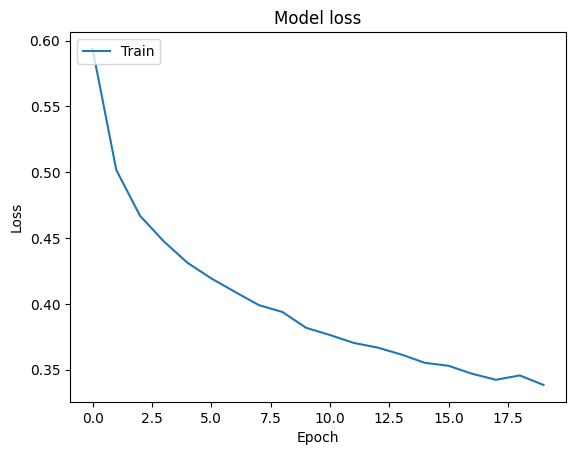

In [36]:
# Tarinnig Model set
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# Function to compute Ideal Binary Mask
def compute_IBM(s, n):
    # S and N are lists of magnitude spectrograms for speech and noise respectively
    IBM = [np.where(s > n, 1, 0) for s, n in zip(s, n)]
    return IBM

# Compute IBM for each pair of S_tr and N_tr
IBM_tr = compute_IBM(S_tr, N_tr)

# Pad the sequences so they are all the same length for batching
def pad_sequences(sequences, max_len=None, freq_bins=None):
    if not max_len:
        max_len = max(seq.shape[1] for seq in sequences)  # Adjusted to index 1 for time dimension
    if not freq_bins:
        freq_bins = sequences[0].shape[0]  # Adjusted to index 0 for frequency dimension
    # Pad all sequences to the length of the longest
    padded = np.array([np.pad(seq, ((0, freq_bins - seq.shape[0]), (0, max_len - seq.shape[1])), 'constant') for seq in sequences])
    return padded


# Pad spectrograms and IBM
freq_bins = X_tr[0].shape[0]  
max_length = max(seq.shape[1] for seq in X_tr)  
X_tr_padded = pad_sequences(X_tr, max_length, freq_bins)
IBM_tr_padded = pad_sequences(IBM_tr, max_length, freq_bins)

print(freq_bins)
print(max_length)

# RNN model
model = Sequential([
    Masking(mask_value=0., input_shape=(None, 513)), 
    GRU(512, return_sequences=True),
    Dropout(0.2),
    GRU(256, return_sequences=True),
    #Dropout(0.1),
    TimeDistributed(Dense(513, activation='sigmoid'))
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Reshape inputs and targets for RNN training
# The RNN expects input of shape (num_samples, num_timesteps, num_features)
X_tr_reshaped = np.transpose(X_tr_padded, (0, 2, 1))
IBM_tr_reshaped = np.transpose(IBM_tr_padded, (0, 2, 1))

# Train the model
history = model.fit(X_tr_reshaped, IBM_tr_reshaped, epochs=20, batch_size=10)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [37]:
# Validation data
V_x = []
V_s = []

for i in range(1200):
    vx_file = f"v/vx{i:04d}.wav"
    vs_file = f"v/vs{i:04d}.wav"
    
    V_x.append(load_and_convert_to_spectrogram(vx_file))
    V_s.append(load_and_convert_to_spectrogram(vs_file))

# Validation data padding
V_x_padded = pad_sequences(V_x, max_length, freq_bins)
V_s_padded = pad_sequences(V_s, max_length, freq_bins)

# Reshape inputs for RNN prediction
V_x_reshaped = np.transpose(V_x_padded, (0, 2, 1))
#V_x_reshaped = V_x_padded
print(V_x_reshaped.shape)

# predict denoised spectrogram 
V_pred_reshaped = model.predict(V_x_reshaped)
V_pred = np.transpose(V_pred_reshaped, (0, 2, 1))

# SNR calculation
snr_list = []
for i in range(len(V_s)):
    predicted_spectrogram = V_pred[i] * V_x_padded[i]
    ground_truth = V_s_padded[i]
    
    signal_energy = np.sum(ground_truth ** 2)
    noise_energy = np.sum((ground_truth - predicted_spectrogram) ** 2)
    snr = 10 * np.log10(signal_energy / noise_energy)
    snr_list.append(snr)

average_snr = np.mean(snr_list)

print(f'Average SNR for the validation set: {average_snr} dB')

(1200, 178, 513)
38/38 [==============================] - 82s 2s/step
Average SNR for the validation set: 11.691921407481034 dB


In [41]:
# Audio signal recovery
import librosa
import soundfile as sf

# Test data load
T_x = []
for i in range(400):
    te_file = f"te/tex{i:04d}.wav"
    T_x.append(load_and_convert_to_spectrogram(te_file))

freq_bins = T_x[0].shape[0]  
max_length = max(seq.shape[1] for seq in T_x) 

    
# padding
T_x_padded = pad_sequences(T_x, max_length, freq_bins)

# Reshape inputs for RNN prediction
T_x_reshaped = np.transpose(T_x_padded, (0, 2, 1))

# Predict
T_pred_reshaped = model.predict(T_x_reshaped)

# Reshape agin 
T_pred = np.transpose(T_pred_reshaped, (0, 2, 1))

# recover audio files
for i, pred in enumerate(T_pred):
    _, current_sr = librosa.load(f"te/tex{i:04d}.wav", sr=None)
    # Extract magnitude and phase from the original padded spectrogram
    original_spectrogram = T_x_padded[i]  # Padded original
    original_magnitude = np.abs(original_spectrogram)
    original_phase = np.angle(original_spectrogram)

    # to create a denoised complex spectrogram
    denoised_magnitude = np.maximum(pred, 0) * original_magnitude 
    denoised_spectrogram = denoised_magnitude * np.exp(1j * original_phase)

    # Recover signal via ISTFT
    recovered_signal = librosa.istft(denoised_spectrogram, hop_length=512)

    sf.write(f'recovered_signals/tex{i:04d}_recovered.wav', recovered_signal, current_sr)

13/13 [==============================] - 28s 2s/step
